# REINFORCE Algorithm

In [1]:
import gym
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from time import sleep

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda:0


### Untrained agent without Reinforcement Learning

In [2]:
env = gym.make('CartPole-v1')
print(env.observation_space)
print(env.action_space)

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Discrete(2)


In [3]:
for i in range(5):
    state = env.reset()
    score = 0
    done = False
    while not done:
        env.render()
        sleep(0.01)
        action = env.action_space.sample()
        state_, reward, done, _ = env.step(action)
        score += reward
        state = state_
    print(f'Episode {i} | Score: {score}')
env.close()

Episode 0 | Score: 35.0
Episode 1 | Score: 14.0
Episode 2 | Score: 17.0
Episode 3 | Score: 12.0
Episode 4 | Score: 19.0


## Building the REINFORCE Model
The ANN takes a state as input and outputs a probability distribution over actions given the state (a policy)

In [4]:
class REINFORCE(nn.Module):
    def __init__(self, state_size, n_actions, lr, save_path, fc1_dims=128, fc2_dims=128):
        super(REINFORCE, self).__init__()
        
        self.fc1 = nn.Linear(*state_size, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.save_path = os.path.join(save_path)
    
    def save_model_checkpoint(self):
        torch.save(self.state_dict(), self.save_path)
    
    def load_model_checkpoint(self):
        print('Loading from ->',self.save_path)
        self.load_state_dict(torch.load(self.save_path))
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        prob_actions = F.softmax(x, dim=0)
        return prob_actions

In [5]:
class Agent:
    def __init__(self, trialnum, env, gamma, lr, NN_params):
        self.env = env
        self.gamma = gamma
        self.trajectory_logprob_actions = []
        self.trajectory_rewards = []
        self.PGNet = REINFORCE(env.observation_space.shape,
                               env.action_space.n,
                               lr,
                               f'checkpoints/REINFORCE/{env.spec.id}_PGNet_trial{trialnum}.pth',
                               *NN_params).to(device)
        
    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(device)
        prob_actions = self.PGNet(state)
        cat_actions = dist.Categorical(prob_actions)
        action = cat_actions.sample()
        log_prob = cat_actions.log_prob(action)
        self.trajectory_logprob_actions.append(log_prob)
        return action.item()
    
    def save_reward(self, reward):
        self.trajectory_rewards.append(reward)
        
    def learn(self):
        self.PGNet.optimizer.zero_grad()
        # G is the array containing the expected return of the trajectory/policy at each timestep of an episode
        G = np.zeros_like(self.trajectory_rewards, dtype=np.float64)
        for t in range(len(self.trajectory_rewards)):
            for j in range(t, len(self.trajectory_rewards)):
                G[t] += self.trajectory_rewards[j]*(self.gamma**(j-t))
        G_norm = (G-np.mean(G))/np.std(G) if np.std(G) > 0 else (G-np.mean(G)) / 1.0
        G_norm = torch.tensor(G_norm, dtype=torch.float).to(device)
        loss = 0
        for t in range(len(G_norm)):
            loss += -G_norm[t]*self.trajectory_logprob_actions[t]
        # Gradient ascent here as we maximise the objective function
        loss.backward()
        self.PGNet.optimizer.step()
        self.trajectory_logprob_actions = []
        self.trajectory_rewards = []        

## Training the Model

In [6]:
%%time
env = gym.make('CartPole-v1')
trialnum = 1
# Hyperparameters
hps = {
    'gamma':0.99,
    'lr':0.001,
    'fc1_dims':128,
    'fc2_dims':128,
}
agent = Agent(
    trialnum = trialnum,
    env=env,
    gamma=hps['gamma'], 
    lr=hps['lr'],
    NN_params=(hps['fc1_dims'], hps['fc2_dims']), 
)
best_score = -np.inf
best_reached_at = -1
scores, avg_scores = [], []
N = 1000
for i in range(N):
    state = env.reset()
    score = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        state_, reward, done, _ = env.step(action)
#         if (i+1) % 50 == 0:
#             env.render()
#             sleep(0.01)
        agent.save_reward(reward)
        score += reward
        state = state_
    agent.learn()
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)
    if avg_score > best_score:
        best_score = avg_score
        best_reached_at = i+1
        agent.PGNet.save_model_checkpoint()
    if avg_score >= 475:
        print(f"Env solved in {i+1} episodes -> {avg_score}")
        break
    if (i+1) % 10 == 0:
        print(f'Episode {i+1} Score: {round(score, 2)} Avg Score: {avg_score:.2f}',
              f'Best Score: {best_score:.2f}')
env.close()

Episode 10 Score: 21.0 Avg Score: 24.70 Best Score: 29.83
Episode 20 Score: 10.0 Avg Score: 23.80 Best Score: 29.83
Episode 30 Score: 27.0 Avg Score: 24.20 Best Score: 29.83
Episode 40 Score: 21.0 Avg Score: 24.20 Best Score: 29.83
Episode 50 Score: 19.0 Avg Score: 24.40 Best Score: 29.83
Episode 60 Score: 12.0 Avg Score: 26.88 Best Score: 29.83
Episode 70 Score: 11.0 Avg Score: 28.86 Best Score: 29.83
Episode 80 Score: 18.0 Avg Score: 31.27 Best Score: 31.56
Episode 90 Score: 13.0 Avg Score: 32.37 Best Score: 32.66
Episode 100 Score: 38.0 Avg Score: 33.58 Best Score: 33.58
Episode 110 Score: 36.0 Avg Score: 39.27 Best Score: 39.27
Episode 120 Score: 67.0 Avg Score: 45.47 Best Score: 45.47
Episode 130 Score: 49.0 Avg Score: 48.20 Best Score: 48.20
Episode 140 Score: 80.0 Avg Score: 53.95 Best Score: 53.95
Episode 150 Score: 88.0 Avg Score: 61.95 Best Score: 61.95
Episode 160 Score: 252.0 Avg Score: 78.18 Best Score: 78.18
Episode 170 Score: 272.0 Avg Score: 100.84 Best Score: 100.84
Ep

### Storing the results and hyperparameters

In [7]:
agent_dict = {'Algorithm':'REINFORCE', 'Trial':trialnum, 'Best Score':best_score, 
              'Best at':best_reached_at, 'Trained till':len(scores), 'hyperparams':hps}
os.chdir(os.path.join(os.getcwd(), 'History'))
with open(f'{env.spec.id}_history.txt', 'a+') as file:
    file.write(f'{agent_dict}\n\n')
os.chdir('../')

## Plotting Scores

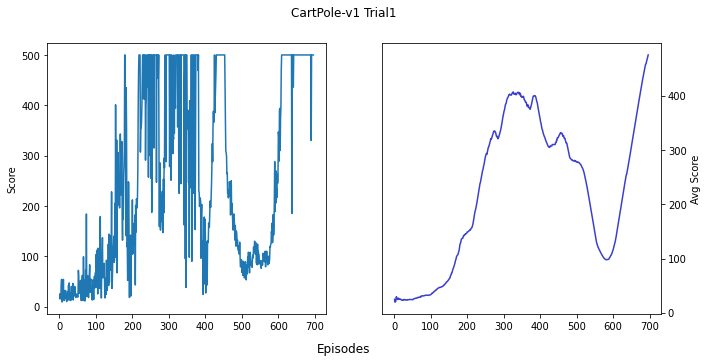

In [8]:
def plot_graph(x, avg_scores, scores, figpath):
    fig = plt.figure(figsize=(11, 5))
    fig.suptitle(f'{env.spec.id} Trial{trialnum}')
    fig.supxlabel("Episodes")
    
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax.plot(x, scores, color='#1f77b4')
    ax.set_ylabel("Score")

    ax2.plot(x, avg_scores, color='#3a3fcf')
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Avg Score')
    ax2.yaxis.set_label_position('right')
    
    plt.savefig(figpath, facecolor='white', transparent=False)


episode_indices = np.arange(1, len(scores)+1) 
figpath = f'graphs/REINFORCE/{env.spec.id}_trial{trialnum}.png'

plot_graph(episode_indices, avg_scores, scores, figpath)

## Testing the Model

In [9]:
env = gym.make('CartPole-v1')
trialnum = 1
# Hyperparameters
hps = {
    'gamma':0.99,
    'lr':0.001,
    'fc1_dims':128,
    'fc2_dims':128,
}
agent = Agent(
    trialnum = trialnum,
    env=env,
    gamma=hps['gamma'], 
    lr=hps['lr'],
    NN_params=(hps['fc1_dims'], hps['fc2_dims']), 
)
agent.PGNet.load_model_checkpoint()

for i in range(5):
    done = False
    score = 0
    state = env.reset()
    while not done:
        env.render()
        sleep(0.01)
        action = agent.choose_action(state)
        state_, reward, done, _ = env.step(action)
        score += reward
        state = state_
    print('\n',score,'\n')
env.close()

Loading from -> checkpoints/REINFORCE/CartPole-v1_PGNet_trial1.pth

 500.0 


 500.0 


 500.0 


 500.0 


 500.0 

